In [69]:
from __future__ import division

import numpy as np
import inspect
import functools
import matplotlib.pyplot as plt

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
import enterprise.signals.signal_base as base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from tests.enterprise_test_data import datadir

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
psr = Pulsar(datadir+'/B1855+09_NANOGrav_11yv0.gls.par', datadir+'/B1855+09_NANOGrav_11yv0.tim')

## Updated fourier design matrix and test function that has `Parameter`s

In [337]:
def createfourierdesignmatrix_red(toas, nmodes=30, Tspan=None,
                                  logf=False, fmin=None, fmax=None,
                                  pshift=False):
    """
    Construct fourier design matrix from eq 11 of Lentati et al, 2013

    :param toas: vector of time series in seconds
    :param nmodes: number of fourier coefficients to use
    :param freq: option to output frequencies
    :param Tspan: option to some other Tspan
    :param logf: use log frequency spacing
    :param fmin: lower sampling frequency
    :param fmax: upper sampling frequency
    :param pshift: option to add random phase shift

    :return: F: fourier design matrix
    :return: f: Sampling frequencies
    """

    N = len(toas)
    F = np.zeros((N, 2 * nmodes))

    T = Tspan if Tspan is not None else toas.max() - toas.min()

    # define sampling frequencies
    if fmin is None:
        fmin = 1 / T
    if fmax is None:
        fmax = nmodes / T

    if logf:
        f = np.logspace(np.log10(fmin), np.log10(fmax), nmodes)
    else:
        f = np.linspace(fmin, fmax, nmodes)

    # add random phase shift to basis functions
    ranphase = (np.random.uniform(0.0, 2 * np.pi, nmodes)
                if pshift else np.zeros(nmodes))

    Ffreqs = np.repeat(f, 2)

    # The sine/cosine modes
    F[:,::2] = np.sin(2*np.pi*toas[:,None]*f[None,:] +
                      ranphase[None,:])
    F[:,1::2] = np.cos(2*np.pi*toas[:,None]*f[None,:] +
                       ranphase[None,:])

    return F, Ffreqs


def createfourierdesignmatrix_env(toas, log10_Amp=-7, log10_Q=np.log10(300), t0=4783728350.5632496, 
                                  nmodes=30, Tspan=None, logf=False, fmin=None, 
                                  fmax=None):


    # get base fourier design matrix and frequencies
    F, Ffreqs = createfourierdesignmatrix_red(
        toas, nmodes=nmodes, Tspan=Tspan, logf=logf,
        fmin=fmin, fmax=fmax)

    # compute gaussian envelope
    A = 10**log10_Amp
    Q = 10**log10_Q * 86400
    env = A * np.exp(-(toas-t0)**2/2/Q**2)
    return F * env[:, None], Ffreqs

## Slightly updated selection function

Can now take positional and keyword arguments

In [338]:
def call_me_maybe(obj):
    """See `here`_ for description.

    .. _here: https://www.youtube.com/watch?v=fWNaR-rxAic
    """
    return obj() if hasattr(obj, '__call__') else obj

def selection_func(func):
    funcargs = inspect.getargspec(func).args
        
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        targs = list(args)
        
        # check for mask
        mask = kwargs.get('mask', Ellipsis)
        if 'mask' in kwargs:
            del kwargs['mask']

        if len(targs) < len(funcargs) and 'psr' in kwargs:
            psr = kwargs['psr']
            
            for funcarg in funcargs[len(args):]:
                if funcarg not in kwargs and hasattr(psr, funcarg):
                    targs.append(call_me_maybe(getattr(psr, funcarg))[mask])
        
        if 'psr' in kwargs and 'psr' not in funcargs:
            del kwargs['psr']

        return func(*targs, **kwargs)

    return wrapper

## New `Function` factory with selection-like functionality

In [339]:
def Function(func, name='', **func_kwargs):
    fname = name
    
    class Function(object):
        def __init__(self, name, psr=None):
            self._func = selection_func(func)
            self._psr = psr
            
            self._params = {}
            self._defaults = {}

            # divide keyword parameters into those that are Parameter classes,
            # Parameter instances (useful for global parameters),
            # and something else (which we will assume is a value)
            for kw, arg in func_kwargs.items():
                if isinstance(arg, type) and issubclass(arg, (parameter.Parameter, parameter.ConstantParameter)):
                    # parameter name template
                    # pname_[signalname_][fname_]parname
                    par = arg(name + '_' + ((fname + '_') if fname else '') + kw)
                    self._params[kw] = par
                elif isinstance(arg, (parameter.Parameter, parameter.ConstantParameter)):
                    self._params[kw] = arg
                else:
                    # we could also extract the value from parameter.ConstantParameter and store it here...
                    self._defaults[kw] = arg
        def __call__(self, *args, **kwargs):
            # order of parameter resolution:
            # - parameter given in kwargs
            # - named sampling parameter in self._params, if given in params dict
            #   or if it has a value
            # - parameter given as constant in Function definition
            # - default value for keyword parameter in func definition
            
            # trick to get positional arguments before params kwarg
            params = kwargs.get('params',{})
            if 'params' in kwargs:
                del kwargs['params']

            for kw, arg in func_kwargs.items():
                if kw not in kwargs and kw in self._params:
                    par = self._params[kw]
                    
                    if par.name in params:
                        kwargs[kw] = params[par.name]
                    elif hasattr(par, 'value'):
                        kwargs[kw] = par.value

            for kw, arg in self._defaults.items():
                if kw not in kwargs:
                    kwargs[kw] = arg
            
            if self._psr is not None and 'psr' not in kwargs:
                kwargs['psr'] = self._psr
            
            return self._func(*args, **kwargs)
                
        @property
        def params(self):
            # if we extract the ConstantParameter value above, we would not
            # need a special case here
            return [par for par in self._params.values() if not
                    isinstance(par, parameter.ConstantParameter)]
    
    return Function

## BasisGP factory

In [340]:
def BasisGP(priorFunction, basisFunction, 
            selection=Selection(selections.no_selection),
            name=''):
    
    class BasisGP(base.Signal):
        signal_type = 'basis'
        signal_name = name
        
        def __init__(self, psr):
            
            self._do_selection(psr, priorFunction, basisFunction, selection)      
        
        def _do_selection(self, psr, priorfn, basisfn, selection):
            
            sel = selection(psr)
            self._keys = list(sorted(sel.masks.keys()))
            self._masks = [sel.masks[key] for key in self._keys]
            self._prior, self._bases, self._params = {}, {}, {}
            for key, mask in zip(self._keys, self._masks):
                pnames = [psr.name, name, key]
                pname = '_'.join([n for n in pnames if n])
                self._prior[key] = priorfn(pname, psr=psr)
                self._bases[key] = basisfn(pname, psr=psr)
                params = sum([self._prior[key].params, self._bases[key].params],[])
                for param in params:
                    self._params[param.name] = param
                    
        def _construct_basis(self, params={}):
            
            basis, self._labels = {}, {}
            for key, mask in zip(self._keys, self._masks):
                basis[key], self._labels[key] = self._bases[key](params=params, mask=mask)
                    
            nc = np.sum(F.shape[1] for F in basis.values())
            self._basis = np.zeros((len(self._masks[0]), nc))
            self._phi = np.zeros(nc)
            self._slices = {}
            nctot = 0
            for key, mask in zip(self._keys, self._masks):
                Fmat = basis[key]
                nn = Fmat.shape[1]
                self._basis[mask, nctot:nn+nctot] = Fmat
                self._slices.update({key: slice(nctot, nn+nctot)})
                nctot += nn
        
        def get_basis(self, params={}):
            self._construct_basis(params)
            return self._basis   

        def get_phi(self, params):
            for key, slc in self._slices.items():
                self._phi[slc] = self._prior[key](self._labels[key], params=params) * self._labels[key][0]
            return self._phi

        def get_phiinv(self, params):
            return 1 / self.get_phi(params)
    
    return BasisGP

## Test out the new method on a Fourier Basis signal with basis parameters

In [341]:
# set up powerlaw spectrum
pl = Function(utils.powerlaw, log10_A=parameter.Uniform(-18,-12), 
              gamma=parameter.Uniform(0, 7))

# set up Gaussian envelope basis function
log10_Amp = parameter.Uniform(-10, -5)
log10_Q = parameter.Uniform(np.log10(30), np.log10(3000))
t0 = parameter.Uniform(psr.toas.min(), psr.toas.max())
fourier_env = Function(createfourierdesignmatrix_env, 
                       t0=t0, log10_Amp=log10_Amp, log10_Q=log10_Q, 
                       nmodes=50)

# make signal
gp = BasisGP(pl, fourier_env, name='')
gpm = gp(psr)

In [342]:
gpm.params

["B1855+09_t0":Uniform(4610193724.96,4957262976.17),
 "B1855+09_log10_A":Uniform(-18,-12),
 "B1855+09_log10_Q":Uniform(1.47712125472,3.47712125472),
 "B1855+09_log10_Amp":Uniform(-10,-5),
 "B1855+09_gamma":Uniform(0,7)]

In [343]:
# parameters
params = {'B1855+09_env_log10_A': -15,
          'B1855+09_env_gamma': 4.33,
          'B1855+09_env_log10_Amp': -8,
          'B1855+09_env_log10_Q': np.log10(300),
          'B1855+09_env_t0': 4783728350.5632496}

F = gpm.get_basis(params)
phi = gpm.get_phi(params)

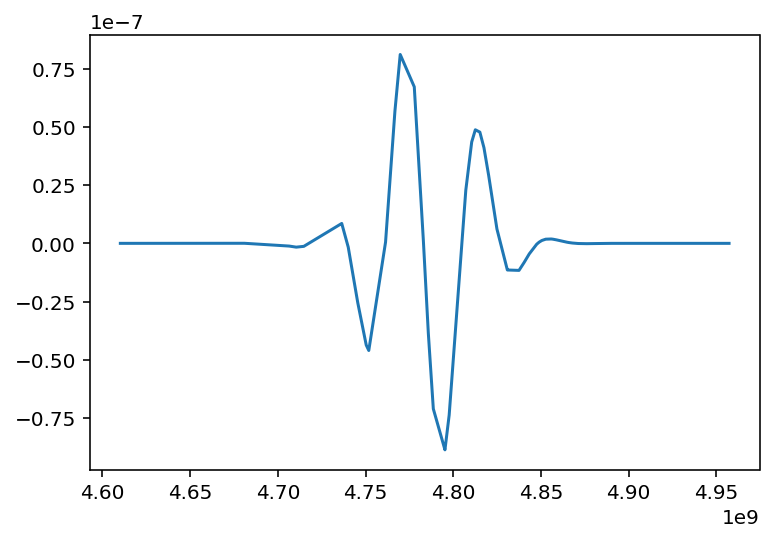

In [344]:
plt.plot(psr.toas, F[:,15])

## Test out the new method with ECORR basis

In [345]:
# slightly modified quantization matrix
def create_quantization_matrix(toas, dt=1, nmin=2):
    """Create quantization matrix mapping TOAs to observing epochs."""
    isort = np.argsort(toas)

    bucket_ref = [toas[isort[0]]]
    bucket_ind = [[isort[0]]]

    for i in isort[1:]:
        if toas[i] - bucket_ref[-1] < dt:
            bucket_ind[-1].append(i)
        else:
            bucket_ref.append(toas[i])
            bucket_ind.append([i])

    # find only epochs with more than 1 TOA
    bucket_ind2 = [ind for ind in bucket_ind if len(ind) >= nmin]

    U = np.zeros((len(toas),len(bucket_ind2)),'d')
    for i,l in enumerate(bucket_ind2):
        U[l,i] = 1
        
    weights = np.ones(U.shape[1])

    return U, weights

# ecorr prior function
def ecorr_basis_prior(weights, log10_ecorr=-8):
    return weights * 10**(2*log10_ecorr)

In [346]:
basisFunction = Function(create_quantization_matrix)
priorFunction = Function(ecorr_basis_prior, log10_ecorr=parameter.Uniform(-10, -5))
selection = Selection(selections.by_backend)

ec = BasisGP(priorFunction, basisFunction, selection=selection)
ecm = ec(psr)

In [347]:
ecm.params

["B1855+09_430_PUPPI_log10_ecorr":Uniform(-10,-5),
 "B1855+09_L-wide_ASP_log10_ecorr":Uniform(-10,-5),
 "B1855+09_430_ASP_log10_ecorr":Uniform(-10,-5),
 "B1855+09_L-wide_PUPPI_log10_ecorr":Uniform(-10,-5)]

In [348]:
params = {'B1855+09_430_PUPPI_log10_ecorr': -7.2, 
          'B1855+09_L-wide_ASP_log10_ecorr': -8.2, 
          'B1855+09_430_ASP_log10_ecorr': -6.4, 
          'B1855+09_L-wide_PUPPI_log10_ecorr': -7}

U = ecm.get_basis(params=params)
phi = ecm.get_phi(params=params)